In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pipe import select, where, sort
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import presentation as p 

# Preparing Data

In [2]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv', index_col=False).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', index_col=False).drop_duplicates()
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv', index_col=False).drop_duplicates()

training_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_class
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal,normal


In [3]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074992 entries, 0 to 1074991
Data columns (total 43 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   duration                     1074992 non-null  int64  
 1   protocol_type                1074992 non-null  object 
 2   service                      1074992 non-null  object 
 3   flag                         1074992 non-null  object 
 4   src_bytes                    1074992 non-null  int64  
 5   dst_bytes                    1074992 non-null  int64  
 6   land                         1074992 non-null  int64  
 7   wrong_fragment               1074992 non-null  int64  
 8   urgent                       1074992 non-null  int64  
 9   hot                          1074992 non-null  int64  
 10  num_failed_logins            1074992 non-null  int64  
 11  logged_in                    1074992 non-null  int64  
 12  num_compromised              1074992 non-n

In [4]:
# Create column to verify if it is an attack or not
training_df['is_attack'] = training_df.target.map(lambda a_type: a_type != 'normal')
testing_df['is_attack'] = testing_df.target.map(lambda a_type: a_type != 'normal')
complete_df['is_attack'] = complete_df.target.map(lambda a_type: a_type != 'normal')

In [5]:
training_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target', 'attack_class', 'is_attack'],
      dtype='object')

# Metrics and reduced Dataset

In [6]:
# Metrics
beta = 10
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

In [7]:
# Important Data Subset (15 Most Important Features)
feature_imp_attack = {
   'same_srv_rate': 0.21199866684770505, 'count': 0.1385794555921013, 'diff_srv_rate': 0.11660354574720663, 
   'src_bytes': 0.07133604504271888, 'flag': 0.0689813541719748, 'dst_host_srv_serror_rate': 0.0621598020912925, 
   'dst_bytes': 0.057168688956664895, 'dst_host_same_srv_rate': 0.05254858459557669, 'srv_serror_rate': 0.04469331875735019, 
   'serror_rate': 0.04097324469080398, 'service': 0.01868051080047695, 'dst_host_serror_rate': 0.01802081827734208, 
   'dst_host_srv_count': 0.011545183650792126, 'dst_host_same_src_port_rate': 0.011337335403034117, 'protocol_type': 0.01111283067949643, 
   'srv_count': 0.009167672319969513, 'dst_host_count': 0.00873490361773566, 'dst_host_srv_rerror_rate': 0.008354143406230159, 
   'dst_host_diff_srv_rate': 0.007982036329319523, 'logged_in': 0.007096409133012435, 'dst_host_srv_diff_host_rate': 0.006912055417103559, 
   'dst_host_rerror_rate': 0.0048513483664072345, 'rerror_rate': 0.0025784179881967813, 'wrong_fragment': 0.0020432908004560796, 
   'srv_rerror_rate': 0.0016133665984154693, 'num_compromised': 0.001456082442758954, 'duration': 0.0013066127485688805, 
   'hot': 0.0012589559107352938, 'srv_diff_host_rate': 0.0006086465735149157, 'is_guest_login': 0.00013464784144864953, 
   'num_root': 4.6925733316063196e-05, 'num_failed_logins': 4.487859382061017e-05, 'num_file_creations': 2.0557845839487765e-05, 
   'root_shell': 1.7416012225572053e-05, 'num_access_files': 1.2171215578937403e-05, 'num_shells': 8.344719212122783e-06, 
   'urgent': 4.825536792287678e-06, 'land': 4.449872331211087e-06, 'su_attempted': 2.354686052141186e-06, 
   'is_host_login': 1.0098642182210754e-07, 'num_outbound_cmds': 0.0
}

feature_imp_attack_class = {
   'count': 0.17385536847050378, 'dst_host_diff_srv_rate': 0.16534192463609285, 'diff_srv_rate': 0.10254320729049028, 
   'dst_host_same_src_port_rate': 0.08935524484241128, 'src_bytes': 0.06294894120539953, 'same_srv_rate': 0.06266221897844468, 
   'srv_count': 0.033477361412496846, 'dst_host_srv_diff_host_rate': 0.02985837864005727, 'dst_host_serror_rate': 0.02397819057338417, 
   'dst_host_rerror_rate': 0.02270848553479628, 'flag': 0.02261474009181149, 'dst_host_count': 0.02122279595653549, 
   'dst_host_srv_count': 0.02018236362613821, 'rerror_rate': 0.019581932778250603, 'service': 0.01929291941472073, 
   'protocol_type': 0.017131606487459122, 'dst_host_same_srv_rate': 0.016847303696007312, 'srv_diff_host_rate': 0.015281253769726545, 
   'serror_rate': 0.01428655250033731, 'logged_in': 0.010248503497316944, 'dst_host_srv_serror_rate': 0.009237924881051724, 
   'wrong_fragment': 0.007985681738000482, 'duration': 0.007656807637643944, 'srv_serror_rate': 0.006918207069047998, 
   'dst_bytes': 0.006286666021650419, 'dst_host_srv_rerror_rate': 0.005842311030619984, 'hot': 0.005058255448651374, 
   'is_guest_login': 0.002493649080574099, 'srv_rerror_rate': 0.0022021571945202234, 'num_compromised': 0.001800962024192526, 
   'num_failed_logins': 0.0004716818681954542, 'root_shell': 0.00018912178300909527, 'num_file_creations': 0.00017914153458179928, 
   'num_root': 9.446178745950394e-05, 'land': 8.349735882600549e-05, 'num_access_files': 3.9353623828989734e-05, 
   'num_shells': 2.1600402461996604e-05, 'urgent': 1.5411543725298135e-05, 'su_attempted': 3.8145695782391786e-06, 
   'num_outbound_cmds': 0.0, 'is_host_login': 0.0
}

def feature(ranking): return ranking[0]
def importance(ranking): return ranking[1]
def top_n_features(n, features):
    return list(
        list(features.items())
        | sort(importance, reverse=True)
        | select(feature)
    )[:n]
def features_above(threshold, features):
    return list(
        list(features.items())
        | where(lambda feature: importance(feature) >= threshold)
        | select(feature)
    )


In [8]:
# For SVM, we will restrict ourselves to the top 15 respective most important features.
top_features_attack = top_n_features(15, feature_imp_attack)
top_features_attack_class = top_n_features(15, feature_imp_attack_class)

In [9]:
# Scale Integer and Float variables
scalable_columns = [col for col in complete_df.columns if complete_df[col].dtype in ['int64', 'float64'] and complete_df[col].nunique() > 2]

# Create copies of the data frames
training_df_scaled = training_df.copy()
testing_df_scaled = testing_df.copy()
complete_df_scaled = complete_df.copy()

scaler = StandardScaler()
for col in scalable_columns:
    training_df_scaled[scalable_columns] = scaler.fit_transform(training_df[scalable_columns])
    testing_df_scaled[scalable_columns] = scaler.transform(testing_df[scalable_columns])
    complete_df_scaled[scalable_columns] = scaler.transform(complete_df[scalable_columns])


In [10]:
# Label encode the target and categorical variables
#object_column_names = [complete_df[col].name for col in complete_df.columns if complete_df[col].dtype == 'object']
categorical_columns = ['protocol_type', 'service', 'flag', 'target', 'attack_class', 'is_attack']

label_encoder = LabelEncoder()
# Fit the label encoder on the complete dataset
for col in categorical_columns:
    label_encoder.fit(complete_df[col])
    training_df[col] = label_encoder.transform(training_df[col])
    testing_df[col] = label_encoder.transform(testing_df[col])
    complete_df[col] = label_encoder.transform(complete_df[col])
    training_df_scaled[col] = label_encoder.transform(training_df_scaled[col])
    testing_df_scaled[col] = label_encoder.transform(testing_df_scaled[col])
    complete_df_scaled[col] = label_encoder.transform(complete_df_scaled[col])
    

## Training and Test Data

In [11]:
# Attack Detection Original Data
X_train_attack = training_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_attack = training_df['is_attack']

X_test_attack = testing_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_attack = testing_df['is_attack']

# Attack Classification Original Data
X_train_class = training_df[training_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_class = training_df[training_df['attack_class'] != 1]['attack_class']

X_test_class = testing_df[testing_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_class = testing_df[testing_df['attack_class'] != 1]['attack_class']

In [12]:
# Top 15 Important Features For Attack Detection
X_train_attack_reduced = training_df[top_features_attack]
y_train_attack_reduced = training_df['is_attack']

X_test_attack_reduced = testing_df[top_features_attack]
y_test_attack_reduced = testing_df['is_attack']

# Top 15 Important Features For Attack Classification
X_train_class_reduced = training_df[training_df['attack_class'] != 1][top_features_attack_class]
y_train_class_reduced = training_df[training_df['attack_class'] != 1]['attack_class']

X_test_class_reduced = testing_df[testing_df['attack_class'] != 1][top_features_attack_class]
y_test_class_reduced = testing_df[testing_df['attack_class'] != 1]['attack_class']

In [13]:
# Attack Detection Scaled Data 
X_train_attack_scaled = training_df_scaled.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_attack_scaled = training_df_scaled['is_attack']

X_test_attack_scaled = testing_df_scaled.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_attack_scaled = testing_df_scaled['is_attack']

# Attack Classification Scaled Data
X_train_class_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_class_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1]['attack_class']

X_test_class_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_class_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1]['attack_class']

In [14]:
# Attack Detection Scaled and Reduced Data
X_train_attack_red_scaled = training_df_scaled[top_features_attack]
y_train_attack_red_scaled = training_df_scaled['is_attack']

X_test_attack_red_scaled = testing_df_scaled[top_features_attack]
y_test_attack_red_scaled = testing_df_scaled['is_attack']

# Attack Classification Scaled and Reduced Data
X_train_class_red_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1][top_features_attack_class]
y_train_class_red_scaled = training_df_scaled[training_df_scaled['attack_class'] != 1]['attack_class']

X_test_class_red_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1][top_features_attack_class]
y_test_class_red_scaled = testing_df_scaled[testing_df_scaled['attack_class'] != 1]['attack_class']

# AdaBoost without and with HPT (Full Dataset)

In [46]:
from sklearn.ensemble import AdaBoostClassifier

In [142]:
# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test, label):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    fbeta = fbeta_score(y_test, predictions, beta=beta, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    print(f'{label} - Accuracy: {accuracy:.4f}, F-beta Score: {fbeta:.4f}, F1-Score: {f1:.4f}')
    print(classification_report(y_test, predictions, zero_division=1))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=p.Colors.purples_c)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()
    
    return accuracy, fbeta, f1

Evaluation of AdaBoost Attack Detection Model without HPT:
AdaBoost Attack Detection without HPT - Accuracy: 0.9216, F-beta Score: 0.9215, F1-Score: 0.9196
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     47913
           1       0.99      0.80      0.89     29378

    accuracy                           0.92     77291
   macro avg       0.94      0.90      0.91     77291
weighted avg       0.93      0.92      0.92     77291



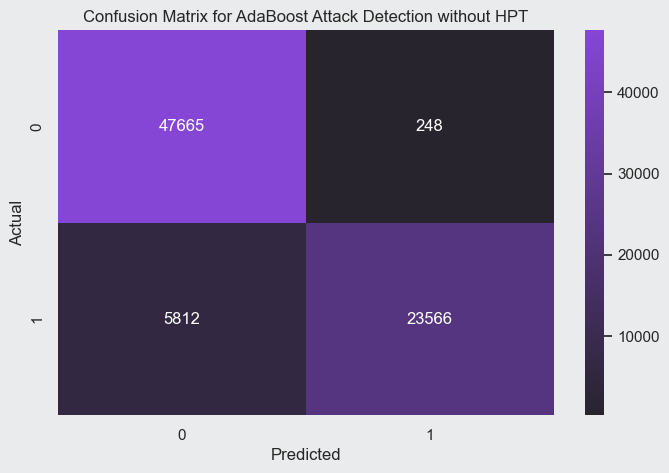

Evaluation of AdaBoost Attack Classification Model without HPT:
AdaBoost Attack Classification without HPT - Accuracy: 0.8836, F-beta Score: 0.8832, F1-Score: 0.8846
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     23747
           2       0.48      0.92      0.63      3041
           3       0.95      0.30      0.46      2533
           4       0.35      0.23      0.28        57

    accuracy                           0.88     29378
   macro avg       0.69      0.60      0.58     29378
weighted avg       0.93      0.88      0.88     29378



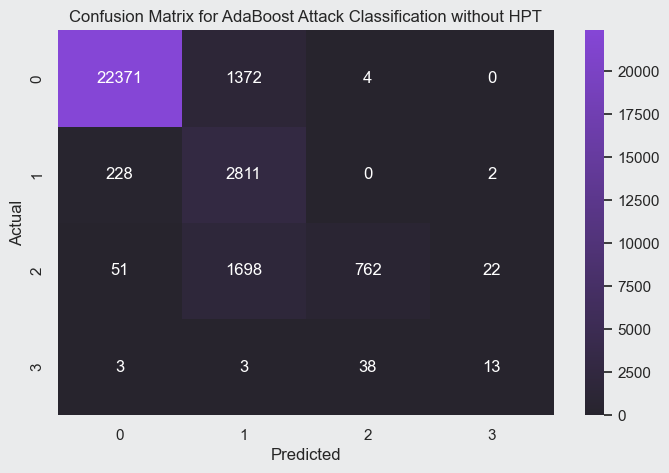

In [60]:
# Train and evaluate AdaBoost models without hyperparameter tuning

# AdaBoost Attack Detection Model without HPT
ada_model_attack = AdaBoostClassifier(n_estimators=100, random_state=404, algorithm='SAMME')
ada_model_attack.fit(X_train_attack, y_train_attack)
print('Evaluation of AdaBoost Attack Detection Model without HPT:')
accuracy_ada_attack, fbeta_ada_attack, f1_ada_attack = evaluate_model(ada_model_attack, X_test_attack, y_test_attack, "AdaBoost Attack Detection without HPT")

# AdaBoost Attack Classification Model without HPT
ada_model_class = AdaBoostClassifier(n_estimators=100, random_state=404, algorithm='SAMME')
ada_model_class.fit(X_train_class, y_train_class)
print('Evaluation of AdaBoost Attack Classification Model without HPT:')
accuracy_ada_class, fbeta_ada_class, f1_ada_class = evaluate_model(ada_model_class, X_test_class, y_test_class, "AdaBoost Attack Classification without HPT")

In [61]:
# Hyperparameter tuning using GridSearchCV
ada_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 1.0],  # Weight applied to each classifier at each boosting iteration
}

Evaluation of AdaBoost Attack Detection Model with HPT:
AdaBoost Attack Detection with HPT - Accuracy: 0.9331, F-beta Score: 0.9330, F1-Score: 0.9318
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291



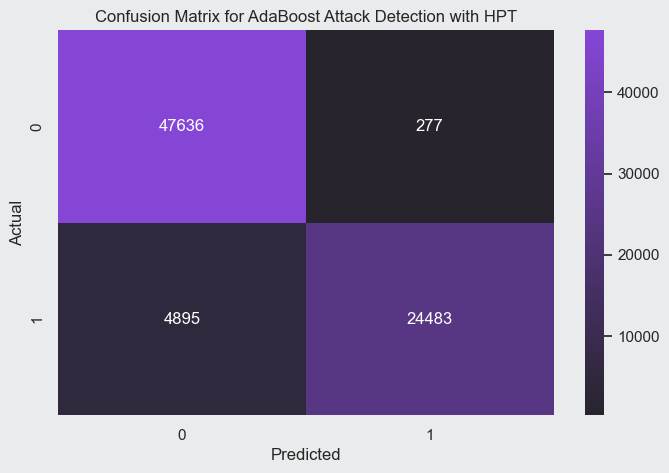

Evaluation of AdaBoost Attack Classification Model with HPT:
AdaBoost Attack Classification with HPT - Accuracy: 0.8661, F-beta Score: 0.8659, F1-Score: 0.8590
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     23747
           2       0.47      0.45      0.46      3041
           3       0.87      0.52      0.65      2533
           4       1.00      0.00      0.00        57

    accuracy                           0.87     29378
   macro avg       0.81      0.48      0.51     29378
weighted avg       0.86      0.87      0.86     29378



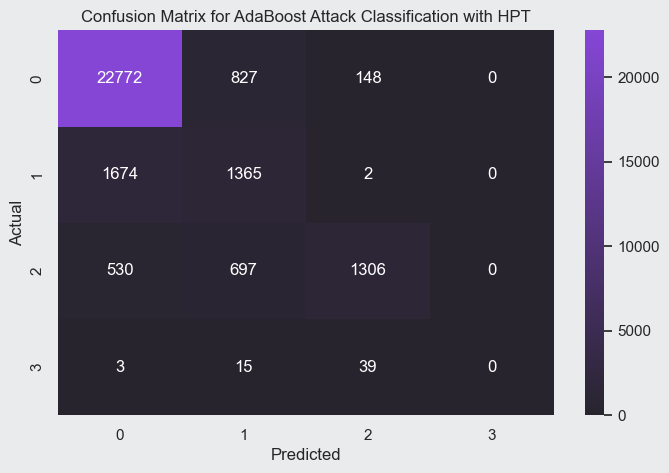

                                        Model  Accuracy  F-beta Score  \
0       AdaBoost Attack Detection without HPT  0.921595       0.92146   
1          AdaBoost Attack Detection with HPT  0.933084       0.93299   
2  AdaBoost Attack Classification without HPT  0.883552       0.88320   
3     AdaBoost Attack Classification with HPT  0.866056       0.86586   

   F1-Score  
0  0.919646  
1  0.931768  
2  0.884560  
3  0.858984  


In [62]:
# GridSearchCV for Attack Detection
grid_search_ada_attack = GridSearchCV(estimator=AdaBoostClassifier(random_state=404, algorithm='SAMME'), param_grid=ada_param_grid, scoring='accuracy', cv=5)
grid_search_ada_attack.fit(X_train_attack, y_train_attack)
best_ada_model_attack = grid_search_ada_attack.best_estimator_
print('Evaluation of AdaBoost Attack Detection Model with HPT:')
accuracy_ada_attack_hpt, fbeta_ada_attack_hpt, f1_ada_attack_hpt = evaluate_model(best_ada_model_attack, X_test_attack, y_test_attack, "AdaBoost Attack Detection with HPT")

# GridSearchCV for Attack Classification
grid_search_ada_class = GridSearchCV(estimator=AdaBoostClassifier(random_state=404, algorithm='SAMME'), param_grid=ada_param_grid, scoring='accuracy', cv=5)
grid_search_ada_class.fit(X_train_class, y_train_class)
best_ada_model_class = grid_search_ada_class.best_estimator_
print('Evaluation of AdaBoost Attack Classification Model with HPT:')
accuracy_ada_class_hpt, fbeta_ada_class_hpt, f1_ada_class_hpt = evaluate_model(best_ada_model_class, X_test_class, y_test_class, "AdaBoost Attack Classification with HPT")

# Compare the results
results_comparison_ada = {
    "Model": ["AdaBoost Attack Detection without HPT", "AdaBoost Attack Detection with HPT", "AdaBoost Attack Classification without HPT", "AdaBoost Attack Classification with HPT"],
    "Accuracy": [accuracy_ada_attack, accuracy_ada_attack_hpt, accuracy_ada_class, accuracy_ada_class_hpt],
    "F-beta Score": [fbeta_ada_attack, fbeta_ada_attack_hpt, fbeta_ada_class, fbeta_ada_class_hpt],
    "F1-Score": [f1_ada_attack, f1_ada_attack_hpt, f1_ada_class, f1_ada_class_hpt]
}

results_df_ada = pd.DataFrame(results_comparison_ada)
print(results_df_ada)

In [183]:
grid_search_ada_attack.best_params_

{'learning_rate': 1.0, 'n_estimators': 200}

In [184]:
grid_search_ada_class.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

# Gradient Boosting without and with HPT (Full Dataset)

In [69]:
from sklearn.ensemble import GradientBoostingClassifier

Evaluation of Gradient Boosting Attack Detection Model without HPT:
Gradient Boosting Attack Detection without HPT - Accuracy: 0.9313, F-beta Score: 0.9312, F1-Score: 0.9299
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     47913
           1       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.94      0.93      0.93     77291



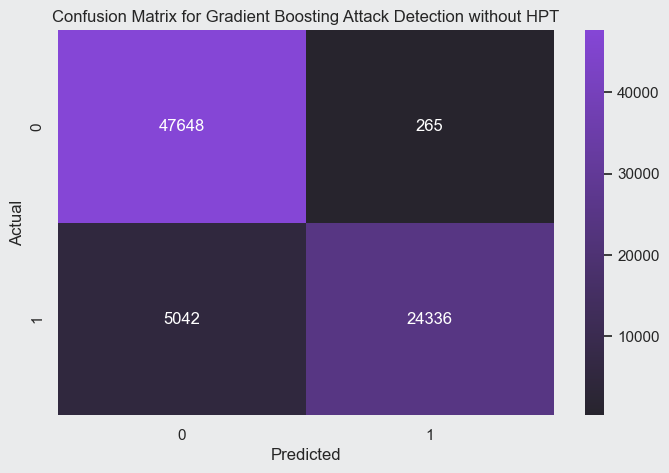

Evaluation of Gradient Boosting Attack Classification Model without HPT:
Gradient Boosting Attack Classification without HPT - Accuracy: 0.8825, F-beta Score: 0.8821, F1-Score: 0.8750
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     23747
           2       0.50      0.84      0.63      3041
           3       0.97      0.23      0.37      2533
           4       0.29      0.49      0.36        57

    accuracy                           0.88     29378
   macro avg       0.68      0.63      0.58     29378
weighted avg       0.92      0.88      0.87     29378



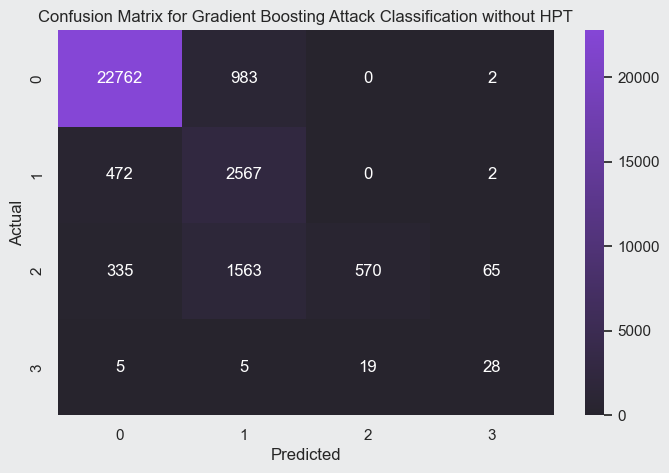

In [70]:
# Train and evaluate Gradient Boosting models without hyperparameter tuning

# Gradient Boosting Attack Detection Model without HPT
gb_model_attack = GradientBoostingClassifier(n_estimators=100, random_state=404)
gb_model_attack.fit(X_train_attack, y_train_attack)
print('Evaluation of Gradient Boosting Attack Detection Model without HPT:')
accuracy_gb_attack, fbeta_gb_attack, f1_gb_attack = evaluate_model(gb_model_attack, X_test_attack, y_test_attack, "Gradient Boosting Attack Detection without HPT")

# Gradient Boosting Attack Classification Model without HPT
gb_model_class = GradientBoostingClassifier(n_estimators=100, random_state=404)
gb_model_class.fit(X_train_class, y_train_class)
print('Evaluation of Gradient Boosting Attack Classification Model without HPT:')
accuracy_gb_class, fbeta_gb_class, f1_gb_class = evaluate_model(gb_model_class, X_test_class, y_test_class, "Gradient Boosting Attack Classification without HPT")

In [71]:
# Hyperparameter tuning using GridSearchCV
gb_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 1.0],  # Weight applied to each classifier at each boosting iteration
    'max_depth': [3, 5, 7]  # Maximum depth of the individual regression estimators
}

Evaluation of Gradient Boosting Attack Detection Model with HPT:
Gradient Boosting Attack Detection with HPT - Accuracy: 0.9347, F-beta Score: 0.9347, F1-Score: 0.9335
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



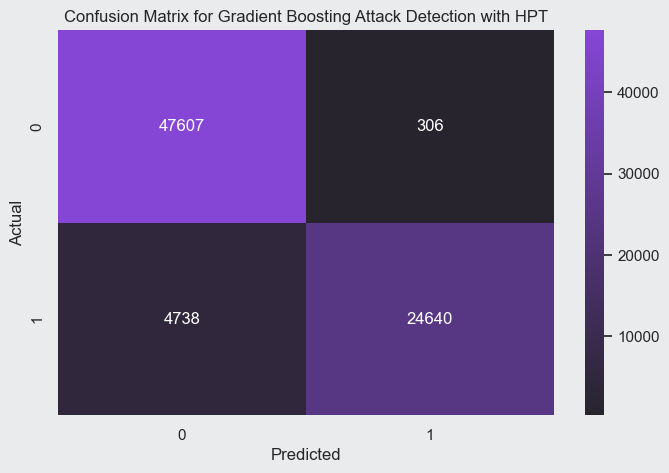

Evaluation of Gradient Boosting Attack Classification Model with HPT:
Gradient Boosting Attack Classification with HPT - Accuracy: 0.8825, F-beta Score: 0.8821, F1-Score: 0.8750
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     23747
           2       0.50      0.84      0.63      3041
           3       0.97      0.23      0.37      2533
           4       0.29      0.49      0.36        57

    accuracy                           0.88     29378
   macro avg       0.68      0.63      0.58     29378
weighted avg       0.92      0.88      0.87     29378



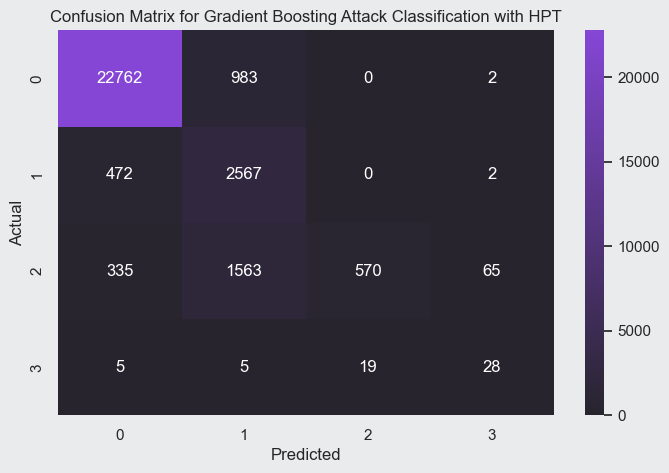

                                               Model  Accuracy  F-beta Score  \
0     Gradient Boosting Attack Detection without HPT  0.931337      0.931237   
1        Gradient Boosting Attack Detection with HPT  0.934740      0.934653   
2  Gradient Boosting Attack Classification withou...  0.882531      0.882142   
3   Gradient Boosting Attack Classification with HPT  0.882531      0.882142   

   F1-Score  
0  0.929929  
1  0.933520  
2  0.874954  
3  0.874954  


In [72]:
# GridSearchCV for Attack Detection
grid_search_gb_attack = GridSearchCV(estimator=GradientBoostingClassifier(random_state=404), param_grid=gb_param_grid, scoring='accuracy', cv=5)
grid_search_gb_attack.fit(X_train_attack, y_train_attack)
best_gb_model_attack = grid_search_gb_attack.best_estimator_
print('Evaluation of Gradient Boosting Attack Detection Model with HPT:')
accuracy_gb_attack_hpt, fbeta_gb_attack_hpt, f1_gb_attack_hpt = evaluate_model(best_gb_model_attack, X_test_attack, y_test_attack, "Gradient Boosting Attack Detection with HPT")

# GridSearchCV for Attack Classification
grid_search_gb_class = GridSearchCV(estimator=GradientBoostingClassifier(random_state=404), param_grid=gb_param_grid, scoring='accuracy', cv=5)
grid_search_gb_class.fit(X_train_class, y_train_class)
best_gb_model_class = grid_search_gb_class.best_estimator_
print('Evaluation of Gradient Boosting Attack Classification Model with HPT:')
accuracy_gb_class_hpt, fbeta_gb_class_hpt, f1_gb_class_hpt = evaluate_model(best_gb_model_class, X_test_class, y_test_class, "Gradient Boosting Attack Classification with HPT")

# Compare the results
results_comparison_gb = {
    "Model": ["Gradient Boosting Attack Detection without HPT", "Gradient Boosting Attack Detection with HPT", "Gradient Boosting Attack Classification without HPT", "Gradient Boosting Attack Classification with HPT"],
    "Accuracy": [accuracy_gb_attack, accuracy_gb_attack_hpt, accuracy_gb_class, accuracy_gb_class_hpt],
    "F-beta Score": [fbeta_gb_attack, fbeta_gb_attack_hpt, fbeta_gb_class, fbeta_gb_class_hpt],
    "F1-Score": [f1_gb_attack, f1_gb_attack_hpt, f1_gb_class, f1_gb_class_hpt]
}

results_df_gb = pd.DataFrame(results_comparison_gb)
print(results_df_gb)

In [185]:
grid_search_gb_attack.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}

In [186]:
grid_search_gb_class.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Evaluation of AdaBoost Attack Detection Model with HPT:
AdaBoost Attack Detection with HPT - Accuracy: 0.9331, F-beta Score: 0.9318, F1-Score: 0.9318
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291



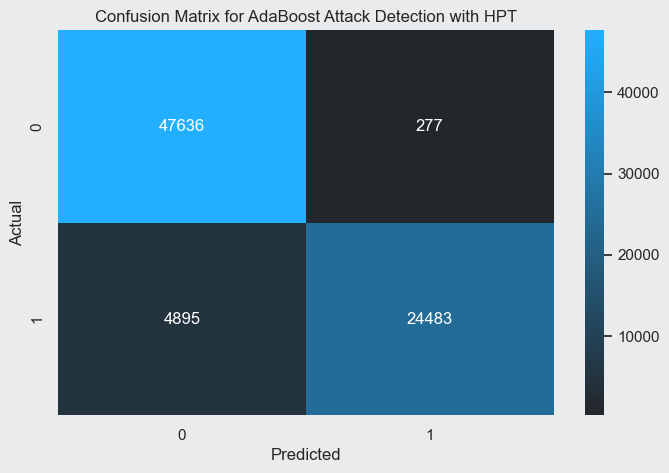

Evaluation of AdaBoost Attack Classification Model with HPT:
AdaBoost Attack Classification with HPT - Accuracy: 0.8661, F-beta Score: 0.8590, F1-Score: 0.8590
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     23747
           2       0.47      0.45      0.46      3041
           3       0.87      0.52      0.65      2533
           4       1.00      0.00      0.00        57

    accuracy                           0.87     29378
   macro avg       0.81      0.48      0.51     29378
weighted avg       0.86      0.87      0.86     29378



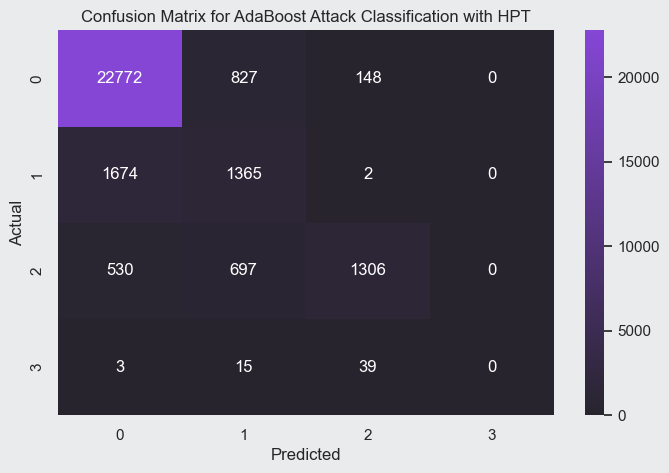

Evaluation of Gradient Boosting Attack Detection Model with HPT:
Gradient Boosting Attack Detection with HPT - Accuracy: 0.9347, F-beta Score: 0.9335, F1-Score: 0.9335
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291



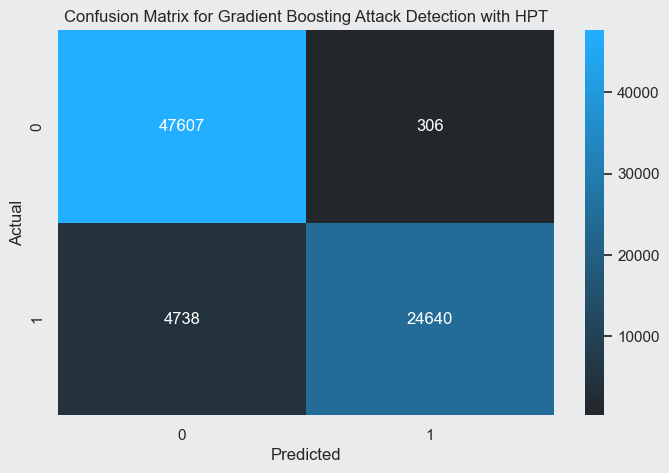

Evaluation of Gradient Boosting Attack Classification Model with HPT:
Gradient Boosting Attack Classification with HPT - Accuracy: 0.8825, F-beta Score: 0.8750, F1-Score: 0.8750
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     23747
           2       0.50      0.84      0.63      3041
           3       0.97      0.23      0.37      2533
           4       0.29      0.49      0.36        57

    accuracy                           0.88     29378
   macro avg       0.68      0.63      0.58     29378
weighted avg       0.92      0.88      0.87     29378



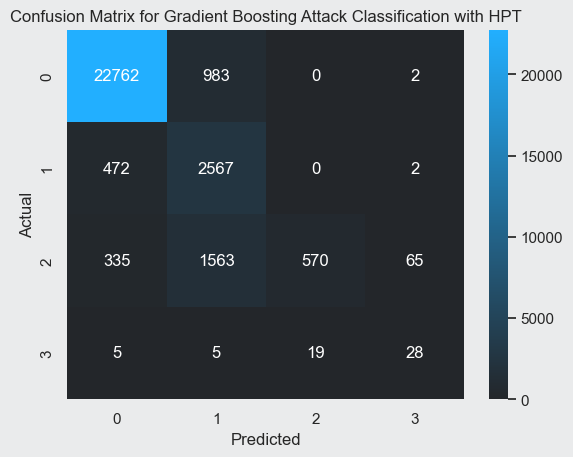

In [204]:
# AdaBoost Attack Detection
print('Evaluation of AdaBoost Attack Detection Model with HPT:')
ada_attack_pred = best_ada_model_attack.predict(X_test_attack)
accuracy_ada_attack_hpt = accuracy_score(y_test_attack, ada_attack_pred)
fbeta_ada_attack_hpt = fbeta_score(y_test_attack, ada_attack_pred, beta=1, average='weighted')  # Adjust beta value as needed
f1_ada_attack_hpt = f1_score(y_test_attack, ada_attack_pred, average='weighted')
print(f'AdaBoost Attack Detection with HPT - Accuracy: {accuracy_ada_attack_hpt:.4f}, F-beta Score: {fbeta_ada_attack_hpt:.4f}, F1-Score: {f1_ada_attack_hpt:.4f}')
print(classification_report(y_test_attack, ada_attack_pred, zero_division=1))

# Confusion Matrix
ada_conf_matrix_attack = confusion_matrix(y_test_attack, ada_attack_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(ada_conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost Attack Detection with HPT')
plt.show()

# AdaBoost Attack Classification
print('Evaluation of AdaBoost Attack Classification Model with HPT:')
ada_class_pred = best_ada_model_class.predict(X_test_class)
accuracy_ada_class_hpt = accuracy_score(y_test_class, ada_class_pred)
fbeta_ada_class_hpt = fbeta_score(y_test_class, ada_class_pred, beta=1, average='weighted')  # Adjust beta value as needed
f1_ada_class_hpt = f1_score(y_test_class, ada_class_pred, average='weighted')
print(f'AdaBoost Attack Classification with HPT - Accuracy: {accuracy_ada_class_hpt:.4f}, F-beta Score: {fbeta_ada_class_hpt:.4f}, F1-Score: {f1_ada_class_hpt:.4f}')
print(classification_report(y_test_class, ada_class_pred, zero_division=1))

# Confusion Matrix
ada_conf_matrix_class = confusion_matrix(y_test_class, ada_class_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(ada_conf_matrix_class, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost Attack Classification with HPT')
plt.show()

# Gradient Boosting Attack Detection
print('Evaluation of Gradient Boosting Attack Detection Model with HPT:')
gb_attack_pred = best_gb_model_attack.predict(X_test_attack)
accuracy_gb_attack_hpt = accuracy_score(y_test_attack, gb_attack_pred)
fbeta_gb_attack_hpt = fbeta_score(y_test_attack, gb_attack_pred, beta=1, average='weighted')  # Adjust beta value as needed
f1_gb_attack_hpt = f1_score(y_test_attack, gb_attack_pred, average='weighted')
print(f'Gradient Boosting Attack Detection with HPT - Accuracy: {accuracy_gb_attack_hpt:.4f}, F-beta Score: {fbeta_gb_attack_hpt:.4f}, F1-Score: {f1_gb_attack_hpt:.4f}')
print(classification_report(y_test_attack, gb_attack_pred, zero_division=1))

# Confusion Matrix
gb_conf_matrix_attack = confusion_matrix(y_test_attack, gb_attack_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(gb_conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Detection with HPT')
plt.show()

# Gradient Boosting Attack Classification
print('Evaluation of Gradient Boosting Attack Classification Model with HPT:')
gb_class_pred = best_gb_model_class.predict(X_test_class)
accuracy_gb_class_hpt = accuracy_score(y_test_class, gb_class_pred)
fbeta_gb_class_hpt = fbeta_score(y_test_class, gb_class_pred, beta=1, average='weighted')  # Adjust beta value as needed
f1_gb_class_hpt = f1_score(y_test_class, gb_class_pred, average='weighted')
print(f'Gradient Boosting Attack Classification with HPT - Accuracy: {accuracy_gb_class_hpt:.4f}, F-beta Score: {fbeta_gb_class_hpt:.4f}, F1-Score: {f1_gb_class_hpt:.4f}')
print(classification_report(y_test_class, gb_class_pred, zero_division=1))

# Confusion Matrix
gb_conf_matrix_class = confusion_matrix(y_test_class, gb_class_pred)
#plt.figure(figsize=(8, 5))
sns.heatmap(gb_conf_matrix_class, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Classification with HPT')
plt.show()


# AdaBoost without and with HPT (Reduced Dataset)

In [163]:
from sklearn.ensemble import AdaBoostClassifier

In [164]:
# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test, label):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    fbeta = fbeta_score(y_test, predictions, beta=beta, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    print(f'{label} - Accuracy: {accuracy:.4f}, F-beta Score: {fbeta:.4f}, F1-Score: {f1:.4f}')
    print(classification_report(y_test, predictions, zero_division=1))
    
    return predictions, accuracy, fbeta, f1

In [165]:
# Train and evaluate AdaBoost models without hyperparameter tuning

# AdaBoost Attack Detection Model without HPT
ada_model_attack_red = AdaBoostClassifier(n_estimators=100, random_state=404, algorithm='SAMME')
ada_model_attack_red.fit(X_train_attack_red_scaled, y_train_attack_red_scaled)
print('Evaluation of AdaBoost Attack Detection Model without HPT:')
ada_attack_pred_red, accuracy_ada_attack_red, fbeta_ada_attack_red, f1_ada_attack_red = evaluate_model(
    ada_model_attack_red, X_test_attack_red_scaled, y_test_attack_red_scaled, "AdaBoost Attack Detection without HPT")

# AdaBoost Attack Classification Model without HPT
ada_model_class_red = AdaBoostClassifier(n_estimators=100, random_state=404, algorithm='SAMME')
ada_model_class_red.fit(X_train_class_red_scaled, y_train_class_red_scaled)
print('Evaluation of AdaBoost Attack Classification Model without HPT:')
ada_class_pred_red, accuracy_ada_class_red, fbeta_ada_class_red, f1_ada_class_red = evaluate_model(
    ada_model_class_red, X_test_class_red_scaled, y_test_class_red_scaled, "AdaBoost Attack Classification without HPT")

Evaluation of AdaBoost Attack Detection Model without HPT:
AdaBoost Attack Detection without HPT - Accuracy: 0.9246, F-beta Score: 0.9245, F1-Score: 0.9229
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     47913
           1       0.99      0.81      0.89     29378

    accuracy                           0.92     77291
   macro avg       0.94      0.90      0.92     77291
weighted avg       0.93      0.92      0.92     77291

Evaluation of AdaBoost Attack Classification Model without HPT:
AdaBoost Attack Classification without HPT - Accuracy: 0.8903, F-beta Score: 0.8901, F1-Score: 0.8898
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     23747
           2       0.53      0.81      0.64      3041
           3       0.97      0.32      0.49      2533
           4       0.02      0.12      0.04        57

    accuracy                           0.89     29378
   macro avg       0.62  

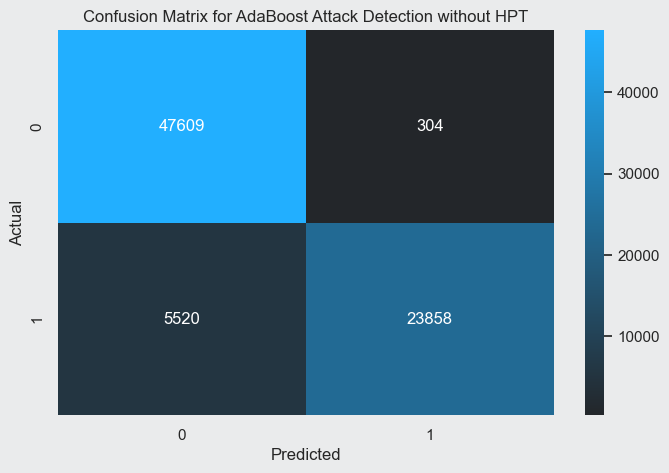

In [166]:
# Confusion Matrix for AdaBoost Attack Detection Model without HPT
plt.figure(figsize=(8, 5))
ada_conf_matrix_attack_red = confusion_matrix(y_test_attack_red_scaled, ada_attack_pred_red)
sns.heatmap(ada_conf_matrix_attack_red, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost Attack Detection without HPT')
plt.show()

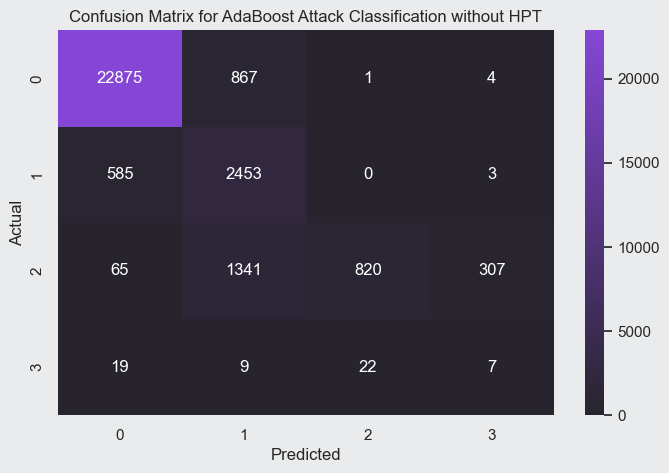

In [167]:
# Confusion Matrix for AdaBoost Attack Classification Model without HPT
plt.figure(figsize=(8, 5))
ada_conf_matrix_class_red = confusion_matrix(y_test_class_red_scaled, ada_class_pred_red)
sns.heatmap(ada_conf_matrix_class_red, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost Attack Classification without HPT')
plt.show()

In [168]:
# Hyperparameter tuning using GridSearchCV
ada_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 1.0],  # Weight applied to each classifier at each boosting iteration
}

In [169]:
# GridSearchCV for Attack Detection
grid_search_ada_attack_red = GridSearchCV(estimator=AdaBoostClassifier(random_state=404, algorithm='SAMME'), param_grid=ada_param_grid, scoring='accuracy', cv=5)
grid_search_ada_attack_red.fit(X_train_attack_red_scaled, y_train_attack_red_scaled)
best_ada_model_attack_red = grid_search_ada_attack_red.best_estimator_
print('Evaluation of AdaBoost Attack Detection Model with HPT:')
ada_attack_pred_hpt_red, accuracy_ada_attack_hpt_red, fbeta_ada_attack_hpt_red, f1_ada_attack_hpt_red = evaluate_model(
    best_ada_model_attack_red, X_test_attack_red_scaled, y_test_attack_red_scaled, "AdaBoost Attack Detection with HPT")

# GridSearchCV for Attack Classification
grid_search_ada_class_red = GridSearchCV(estimator=AdaBoostClassifier(random_state=404, algorithm='SAMME'), param_grid=ada_param_grid, scoring='accuracy', cv=5)
grid_search_ada_class_red.fit(X_train_class_red_scaled, y_train_class_red_scaled)
best_ada_model_class_red = grid_search_ada_class_red.best_estimator_
print('Evaluation of AdaBoost Attack Classification Model with HPT:')
ada_class_pred_hpt_red, accuracy_ada_class_hpt_red, fbeta_ada_class_hpt_red, f1_ada_class_hpt_red = evaluate_model(
    best_ada_model_class_red, X_test_class_red_scaled, y_test_class_red_scaled, "AdaBoost Attack Classification with HPT")

# Compare the results
results_comparison_ada_red = {
    "Model": ["AdaBoost Attack Detection without HPT", "AdaBoost Attack Detection with HPT", "AdaBoost Attack Classification without HPT", "AdaBoost Attack Classification with HPT"],
    "Accuracy": [accuracy_ada_attack_red, accuracy_ada_attack_hpt_red, accuracy_ada_class_red, accuracy_ada_class_hpt_red],
    "F-beta Score": [fbeta_ada_attack_red, fbeta_ada_attack_hpt_red, fbeta_ada_class_red, fbeta_ada_class_hpt_red],
    "F1-Score": [f1_ada_attack_red, f1_ada_attack_hpt_red, f1_ada_class_red, f1_ada_class_hpt_red]
}

results_df_ada_red = pd.DataFrame(results_comparison_ada_red)
print(results_df_ada_red)

Evaluation of AdaBoost Attack Detection Model with HPT:
AdaBoost Attack Detection with HPT - Accuracy: 0.9268, F-beta Score: 0.9267, F1-Score: 0.9252
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     47913
           1       0.99      0.82      0.89     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

Evaluation of AdaBoost Attack Classification Model with HPT:
AdaBoost Attack Classification with HPT - Accuracy: 0.8478, F-beta Score: 0.8475, F1-Score: 0.8415
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     23747
           2       0.35      0.49      0.41      3041
           3       0.79      0.26      0.39      2533
           4       1.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.77      0.43    

In [187]:
grid_search_ada_attack_red.best_params_

{'learning_rate': 1.0, 'n_estimators': 200}

In [188]:
grid_search_ada_class_red.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

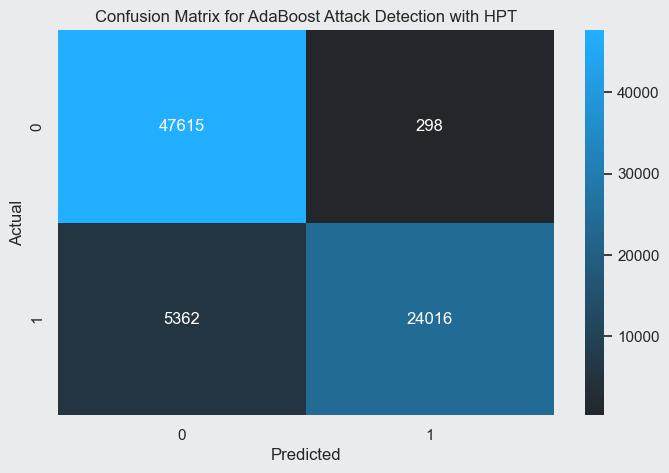

In [171]:
# Confusion Matrix for AdaBoost Attack Detection Model with HPT
plt.figure(figsize=(8, 5))
ada_conf_matrix_attack_hpt_red = confusion_matrix(y_test_attack_red_scaled, ada_attack_pred_hpt_red)
sns.heatmap(ada_conf_matrix_attack_hpt_red, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost Attack Detection with HPT')
plt.show()

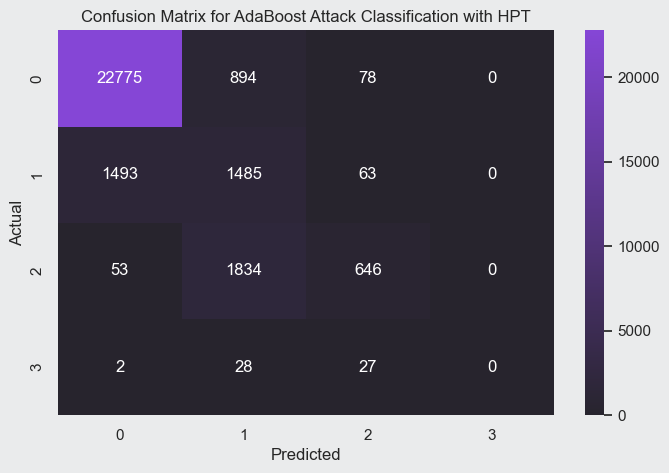

In [205]:
# Confusion Matrix for AdaBoost Attack Classification Model with HPT
plt.figure(figsize=(8, 5))
ada_conf_matrix_class_hpt_red = confusion_matrix(y_test_class_red_scaled, ada_class_pred_hpt_red)
sns.heatmap(ada_conf_matrix_class_hpt_red, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost Attack Classification with HPT')
plt.show()

# Gradient Boosting without and with HPT (Reduced Dataset)

In [173]:
from sklearn.ensemble import GradientBoostingClassifier

In [174]:
# Train and evaluate Gradient Boosting models without hyperparameter tuning

# Gradient Boosting Attack Detection Model without HPT
gb_model_attack_red = GradientBoostingClassifier(n_estimators=100, random_state=404)
gb_model_attack_red.fit(X_train_attack_red_scaled, y_train_attack_red_scaled)
print('Evaluation of Gradient Boosting Attack Detection Model without HPT:')
gb_attack_pred_red, accuracy_gb_attack_red, fbeta_gb_attack_red, f1_gb_attack_red = evaluate_model(
    gb_model_attack_red, X_test_attack_red_scaled, y_test_attack_red_scaled, "Gradient Boosting Attack Detection without HPT")

# Gradient Boosting Attack Classification Model without HPT
gb_model_class_red = GradientBoostingClassifier(n_estimators=100, random_state=404)
gb_model_class_red.fit(X_train_class_red_scaled, y_train_class_red_scaled)
print('Evaluation of Gradient Boosting Attack Classification Model without HPT:')
gb_class_pred_red, accuracy_gb_class_red, fbeta_gb_class_red, f1_gb_class_red = evaluate_model(
    gb_model_class_red, X_test_class_red_scaled, y_test_class_red_scaled, "Gradient Boosting Attack Classification without HPT")

Evaluation of Gradient Boosting Attack Detection Model without HPT:
Gradient Boosting Attack Detection without HPT - Accuracy: 0.9344, F-beta Score: 0.9344, F1-Score: 0.9332
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.84      0.91     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.93      0.93     77291

Evaluation of Gradient Boosting Attack Classification Model without HPT:
Gradient Boosting Attack Classification without HPT - Accuracy: 0.9244, F-beta Score: 0.9243, F1-Score: 0.9230
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     23747
           2       0.75      0.78      0.76      3041
           3       0.72      0.62      0.66      2533
           4       0.16      0.18      0.17        57

    accuracy                           0.92

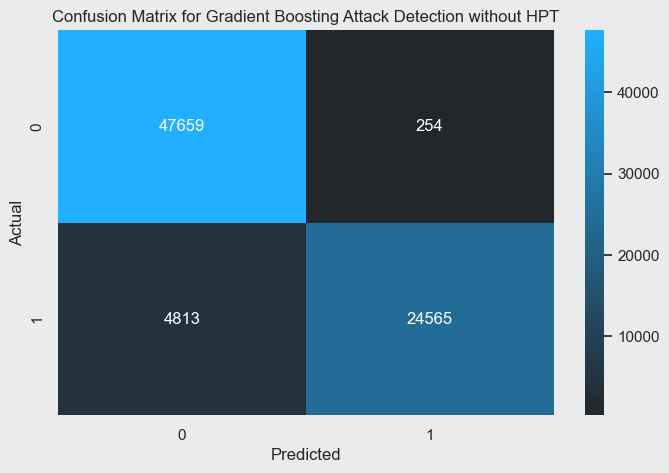

In [176]:
# Confusion Matrix for Gradient Boosting Attack Detection Model without HPT
plt.figure(figsize=(8, 5))
gb_conf_matrix_attack_red = confusion_matrix(y_test_attack_red_scaled, gb_attack_pred_red)
sns.heatmap(gb_conf_matrix_attack_red, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Detection without HPT')
plt.show()

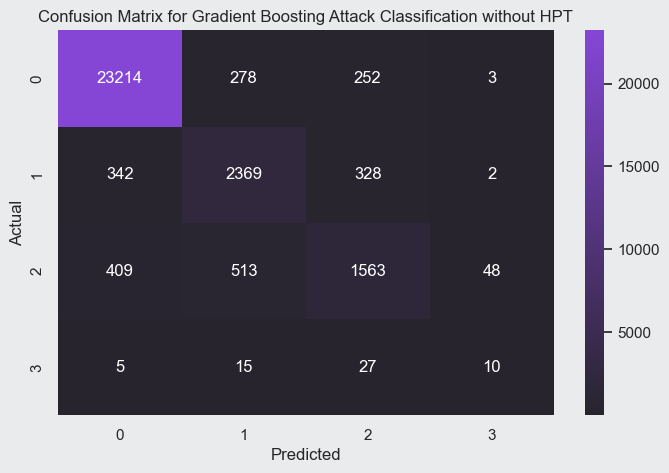

In [177]:
# Confusion Matrix for Gradient Boosting Attack Classification Model without HPT
plt.figure(figsize=(8, 5))
gb_conf_matrix_class_red = confusion_matrix(y_test_class_red_scaled, gb_class_pred_red)
sns.heatmap(gb_conf_matrix_class_red, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Classification without HPT')
plt.show()

In [189]:
# Hyperparameter tuning using GridSearchCV
gb_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 1.0],  # Weight applied to each classifier at each boosting iteration
    'max_depth': [3, 5, 7]  # Maximum depth of the individual regression estimators
}

In [199]:
# GridSearchCV for Attack Detection
grid_search_gb_attack_red = GridSearchCV(estimator=GradientBoostingClassifier(random_state=404), param_grid=gb_param_grid, scoring='accuracy', cv=5)
grid_search_gb_attack_red.fit(X_train_attack_red_scaled, y_train_attack_red_scaled)
best_gb_model_attack_red = grid_search_gb_attack_red.best_estimator_
print('Evaluation of Gradient Boosting Attack Detection Model with HPT:')
gb_attack_pred_hpt_red, accuracy_gb_attack_hpt_red, fbeta_gb_attack_hpt_red, f1_gb_attack_hpt_red = evaluate_model(
    best_gb_model_attack_red, X_test_attack_red_scaled, y_test_attack_red_scaled, "Gradient Boosting Attack Detection with HPT")

# GridSearchCV for Attack Classification
grid_search_gb_class_red = GridSearchCV(estimator=GradientBoostingClassifier(random_state=404), param_grid=gb_param_grid, scoring='accuracy', cv=5)
grid_search_gb_class_red.fit(X_train_class_red_scaled, y_train_class_red_scaled)
best_gb_model_class_red = grid_search_gb_class_red.best_estimator_
print('Evaluation of Gradient Boosting Attack Classification Model with HPT:')
gb_class_pred_hpt_red, accuracy_gb_class_hpt_red, fbeta_gb_class_hpt_red, f1_gb_class_hpt_red = evaluate_model(
    best_gb_model_class_red, X_test_class_red_scaled, y_test_class_red_scaled, "Gradient Boosting Attack Classification with HPT")

# Compare the results
results_comparison_gb_red = {
    "Model": ["Gradient Boosting Attack Detection without HPT", "Gradient Boosting Attack Detection with HPT", "Gradient Boosting Attack Classification without HPT", "Gradient Boosting Attack Classification with HPT"],
    "Accuracy": [accuracy_gb_attack_red, accuracy_gb_attack_hpt_red, accuracy_gb_class_red, accuracy_gb_class_hpt_red],
    "F-beta Score": [fbeta_gb_attack_red, fbeta_gb_attack_hpt_red, fbeta_gb_class_red, fbeta_gb_class_hpt_red],
    "F1-Score": [f1_gb_attack_red, f1_gb_attack_hpt_red, f1_gb_class_red, f1_gb_class_hpt_red]
}

results_df_gb_red = pd.DataFrame(results_comparison_gb_red)
print(results_df_gb_red)

Evaluation of Gradient Boosting Attack Detection Model with HPT:
Gradient Boosting Attack Detection with HPT - Accuracy: 0.9322, F-beta Score: 0.9321, F1-Score: 0.9309
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     47913
           1       0.99      0.83      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291

Evaluation of Gradient Boosting Attack Classification Model with HPT:
Gradient Boosting Attack Classification with HPT - Accuracy: 0.8895, F-beta Score: 0.8896, F1-Score: 0.8992
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23747
           2       0.81      0.78      0.79      3041
           3       0.69      0.39      0.50      2533
           4       0.01      0.23      0.02        57

    accuracy                           0.89     29378
 

In [200]:
grid_search_gb_attack_red.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [201]:
grid_search_gb_class_red.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

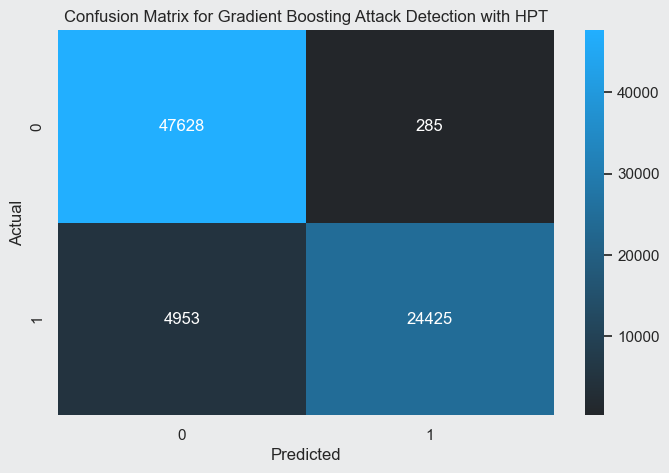

In [202]:
# Confusion Matrix for Gradient Boosting Attack Detection Model without HPT
plt.figure(figsize=(8, 5))
gb_conf_matrix_attack_red_best = confusion_matrix(y_test_attack_red_scaled, gb_attack_pred_hpt_red)
sns.heatmap(gb_conf_matrix_attack_red_best, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Detection with HPT')
plt.show()

In [ ]:
# Confusion Matrix for Gradient Boosting Attack Classification Model without HPT
plt.figure(figsize=(8, 5))
gb_conf_matrix_class_red_best = confusion_matrix(y_test_class_red_scaled, gb_class_pred_hpt_red)
sns.heatmap(gb_conf_matrix_class_red_best, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Classification with HPT')
plt.show()

# Testing out given Parameters from Full Dataset
- Attack Detection: learning_rate=0.1, max_depth=7, n_estimators=100
- Attack Classification: learning_rate=0.1, max_depth=3, n_estimators=100

In [192]:
# Train and evaluate Gradient Boosting models without hyperparameter tuning

# Gradient Boosting Attack Detection Model without HPT
gb_model_attack_red_best = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, n_estimators=100, random_state=404)
gb_model_attack_red_best.fit(X_train_attack_red_scaled, y_train_attack_red_scaled)
print('Evaluation of Gradient Boosting Attack Detection Model with HPT:')
gb_attack_pred_red_best, accuracy_gb_attack_red, fbeta_gb_attack_red, f1_gb_attack_red = evaluate_model(
    gb_model_attack_red_best, X_test_attack_red_scaled, y_test_attack_red_scaled, "Gradient Boosting Attack Detection with HPT")

# Gradient Boosting Attack Classification Model without HPT
gb_model_class_red_best = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=404)
gb_model_class_red_best.fit(X_train_class_red_scaled, y_train_class_red_scaled)
print('Evaluation of Gradient Boosting Attack Classification Model with HPT:')
gb_class_pred_red_best, accuracy_gb_class_red, fbeta_gb_class_red, f1_gb_class_red = evaluate_model(
    gb_model_class_red_best, X_test_class_red_scaled, y_test_class_red_scaled, "Gradient Boosting Attack Classification with HPT")

Evaluation of Gradient Boosting Attack Detection Model with HPT:
Gradient Boosting Attack Detection with HPT - Accuracy: 0.9287, F-beta Score: 0.9286, F1-Score: 0.9271
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     47913
           1       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

Evaluation of Gradient Boosting Attack Classification Model with HPT:
Gradient Boosting Attack Classification with HPT - Accuracy: 0.9244, F-beta Score: 0.9243, F1-Score: 0.9230
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     23747
           2       0.75      0.78      0.76      3041
           3       0.72      0.62      0.66      2533
           4       0.16      0.18      0.17        57

    accuracy                           0.92     29378
 

In [194]:
# Compare the results
results_comparison_gb_red = {
    "Model": ["Gradient Boosting Attack Detection with HPT", "Gradient Boosting Attack Classification with HPT"],
    "Accuracy": [accuracy_gb_attack_red, accuracy_gb_class_red],
    "F-beta Score": [fbeta_gb_attack_red, fbeta_gb_class_red],
    "F1-Score": [f1_gb_attack_red, f1_gb_class_red]
}

results_df_gb_red = pd.DataFrame(results_comparison_gb_red)
print(results_df_gb_red)

Evaluation of Gradient Boosting Attack Detection Model with HPT:
Gradient Boosting Attack Detection with HPT - Accuracy: 0.9287, F-beta Score: 0.9286, F1-Score: 0.9271
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     47913
           1       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291

Evaluation of Gradient Boosting Attack Classification Model with HPT:
Gradient Boosting Attack Classification with HPT - Accuracy: 0.9244, F-beta Score: 0.9243, F1-Score: 0.9230
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     23747
           2       0.75      0.78      0.76      3041
           3       0.72      0.62      0.66      2533
           4       0.16      0.18      0.17        57

    accuracy                           0.92     29378
 

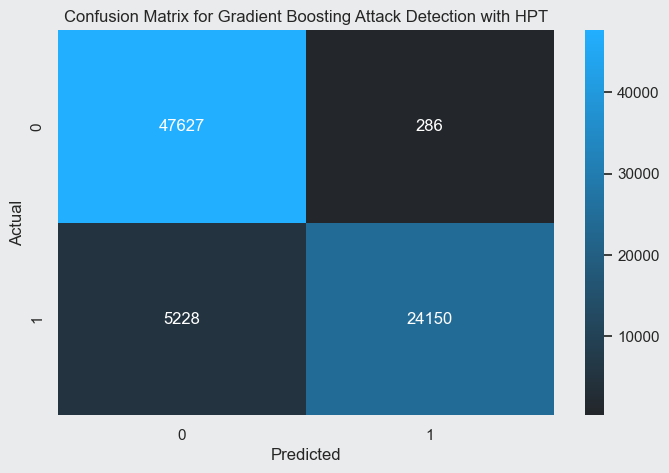

In [198]:
# Confusion Matrix for Gradient Boosting Attack Detection Model with HPT
plt.figure(figsize=(8, 5))
gb_conf_matrix_attack_hpt_red = confusion_matrix(y_test_attack_red_scaled, gb_attack_pred_red_best)
sns.heatmap(gb_conf_matrix_attack_hpt_red, annot=True, fmt='d', cmap=p.Colors.blues_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Detection with HPT')
plt.show()

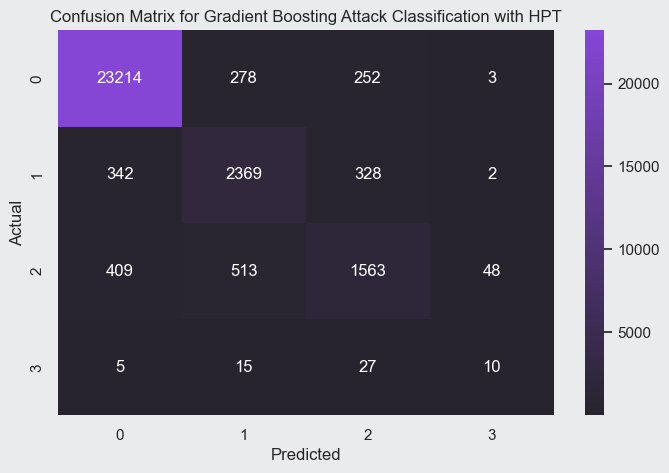

In [196]:
# Confusion Matrix for Gradient Boosting Attack Classification Model with HPT
plt.figure(figsize=(8, 5))
gb_conf_matrix_class_hpt_red = confusion_matrix(y_test_class_red_scaled, gb_class_pred_red_best)
sns.heatmap(gb_conf_matrix_class_hpt_red, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Attack Classification with HPT')
plt.show()